In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import scipy as sp 
import scipy.ndimage as ndimage
import math
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import warnings

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, roc_curve, auc, accuracy_score, classification_report


import seaborn as sns
import random
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [12]:
from skimage import color

def extract_intensity_and_color_features(original_roi):
    # Convert the image to a NumPy array
    original_roi_array = np.array(original_roi)

    # Ensure that the image is in RGB format
    if original_roi_array.ndim == 2:
        original_roi_array = color.gray2rgb(original_roi_array)

    # Calculate intensity features
    mean_intensity = np.mean(original_roi_array)
    std_intensity = np.std(original_roi_array)
    max_intensity = np.max(original_roi_array)
    min_intensity = np.min(original_roi_array)

    # Separate channels
    r_channel, g_channel, b_channel = cv2.split(original_roi_array)

    # Calculate color features in RGB
    mean_r, mean_g, mean_b = np.mean(r_channel), np.mean(g_channel), np.mean(b_channel)
    std_r, std_g, std_b = np.std(r_channel), np.std(g_channel), np.std(b_channel)
    max_r, max_g, max_b = np.max(r_channel), np.max(g_channel), np.max(b_channel)
    min_r, min_g, min_b = np.min(r_channel), np.min(g_channel), np.min(b_channel)

    # Convert the image to HSV
    hsv_image = color.rgb2hsv(original_roi_array)

    # Separate HSV channels
    h_channel, s_channel, v_channel = cv2.split(hsv_image)

    # Calculate color features in HSV
    mean_h, mean_s, mean_v = np.mean(h_channel), np.mean(s_channel), np.mean(v_channel)
    std_h, std_s, std_v = np.std(h_channel), np.std(s_channel), np.std(v_channel)
    max_h, max_s, max_v = np.max(h_channel), np.max(s_channel), np.max(v_channel)
    min_h, min_s, min_v = np.min(h_channel), np.min(s_channel), np.min(v_channel)

    features = {
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'max_intensity': max_intensity,
        'min_intensity': min_intensity,
        'mean_r': mean_r, 'mean_g': mean_g, 'mean_b': mean_b,
        'std_r': std_r, 'std_g': std_g, 'std_b': std_b,
        'max_r': max_r, 'max_g': max_g, 'max_b': max_b,
        'min_r': min_r, 'min_g': min_g, 'min_b': min_b,
        'mean_h': mean_h, 'mean_s': mean_s, 'mean_v': mean_v,
        'std_h': std_h, 'std_s': std_s, 'std_v': std_v,
        'max_h': max_h, 'max_s': max_s, 'max_v': max_v,
        'min_h': min_h, 'min_s': min_s, 'min_v': min_v,
    }

    return features


In [3]:
# Define file path
tr_dir_path = "train"
tr_nevus = os.path.join(tr_dir_path, "nevus")                                      
tr_others = os.path.join(tr_dir_path, "others")                                   

In [4]:
# Initialize lists to store data
tr_image_names = []; tr_image_files = []; tr_gtruth = []

# Define the target size for resizing
target_size = (256, 256)

# Function to resize and load images
def load_and_resize_image(file_path):
    img = Image.open(file_path)
    img = img.resize(target_size)
    return img


# For nevus images (groundtruth = 0)
for nevus_img in tqdm(os.listdir(tr_nevus), desc = "Nevus"):
    tr_image_names.append(nevus_img)
    tr_image_files.append(os.path.join(tr_nevus, nevus_img))
    tr_gtruth.append(0)
    
# For others images (groundtruth = 1)
for others_img in tqdm(os.listdir(tr_others), desc = "Others"):
    tr_image_names.append(others_img)
    tr_image_files.append(os.path.join(tr_others, others_img))
    tr_gtruth.append(1)
    

Others: 100%|██████████| 7470/7470 [00:00<00:00, 185539.22it/s]


In [5]:
# Create a dataframe
tr_data = {"tr_img_name":tr_image_names, "tr_img_file":tr_image_files, "tr_gtruth":tr_gtruth}
tr_df = pd.DataFrame(tr_data)
tr_df = shuffle(tr_df).reset_index(drop=True)
# Resize images
tr_df['resized_images'] = tr_df['tr_img_file'].apply(load_and_resize_image)

tr_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images
0,nev03732.jpg,train\nevus\nev03732.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
1,nev02892.jpg,train\nevus\nev02892.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
2,nev01360.jpg,train\nevus\nev01360.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
3,vac00063.jpg,train\others\vac00063.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
4,mel01704.jpg,train\others\mel01704.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...


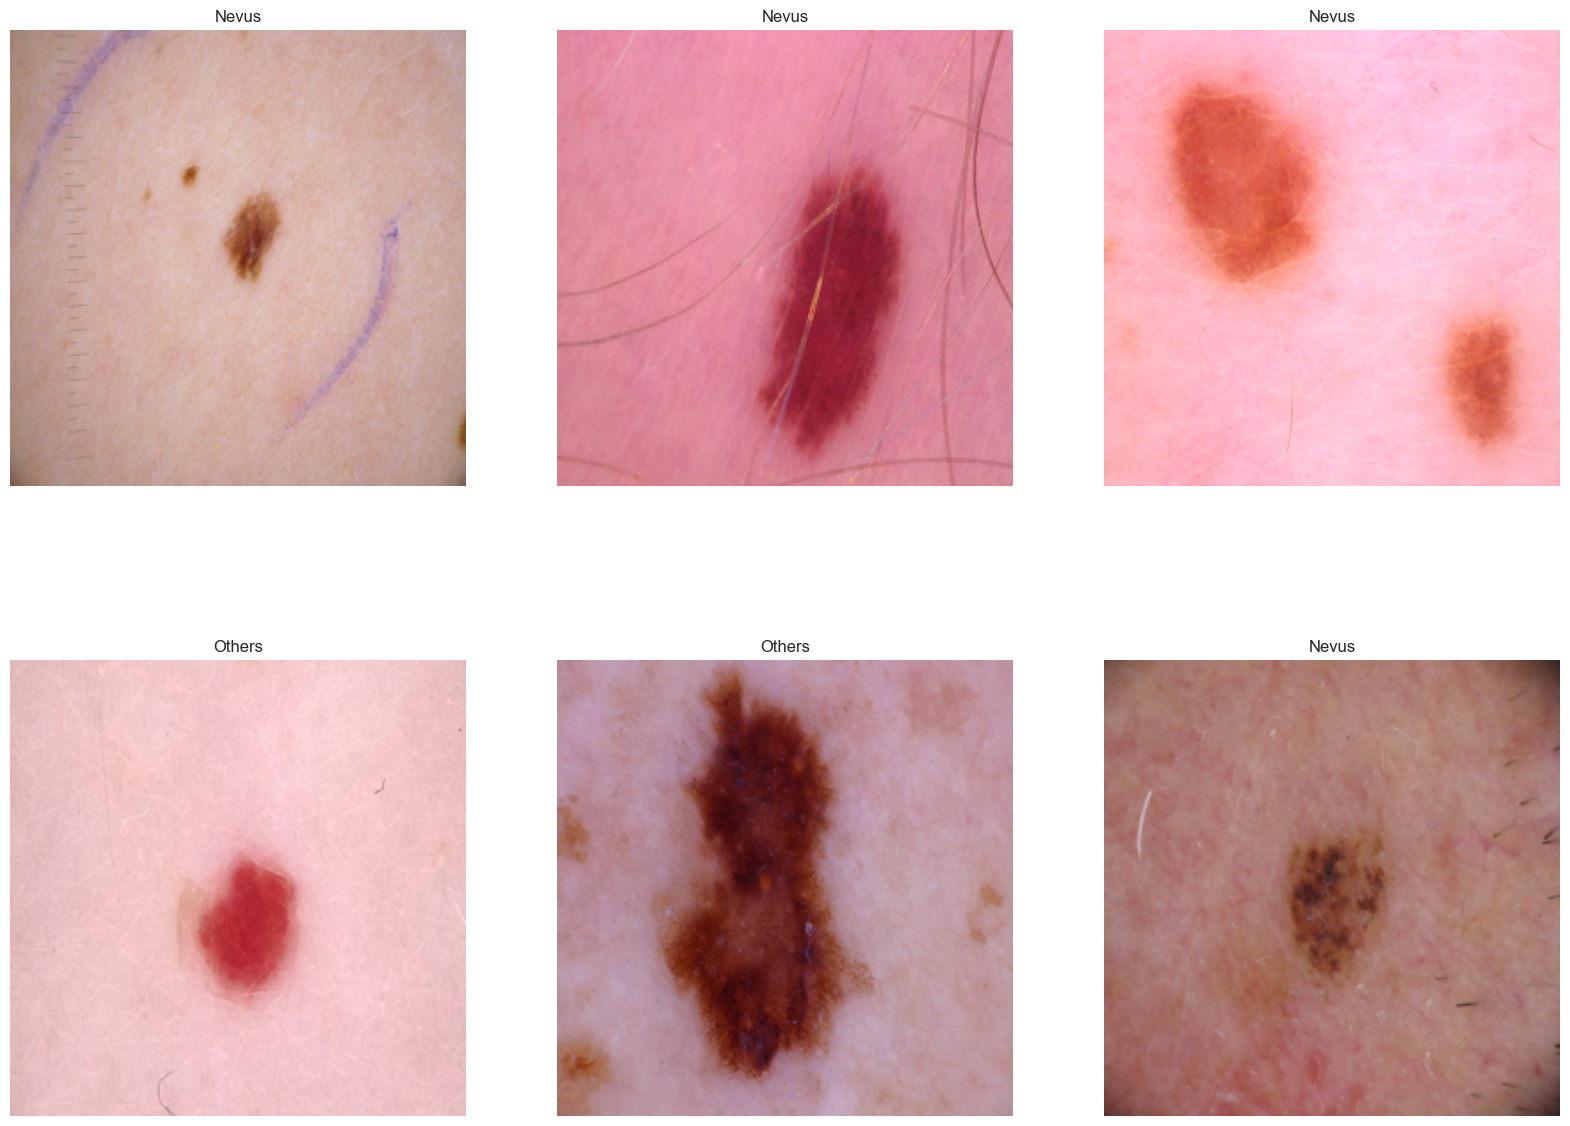

In [6]:
# Set the seaborn style
sns.set_style("white")

# Create a figure
plt.figure(figsize=[20, 15])

for i, (image_path, ground_truth) in enumerate(zip(tr_df["resized_images"][:6], tr_df["tr_gtruth"][:6])):
    # Set the title based on ground truth
    title = "Nevus" if ground_truth == 0 else "Others"
    
    # Plot the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image_path)
    plt.axis("off")
    plt.title(title)

plt.show()

In [13]:
# intensity_features = pd.DataFrame()
# intensity_features = intensity_features.append(extract_intensity_features(tr_df['resized_images']), ignore_index=True)

# # Combine all the features into one data frame
# train_df = pd.concat([intensity_features, tr_df], axis=1)

intensity_features = pd.DataFrame()
intensity_features_list = []

for index, row in tr_df.iterrows():
    resized_image = row['resized_images']
    features = extract_intensity_and_color_features(resized_image)
    intensity_features_list.append(pd.DataFrame(features, index=[0]))

intensity_features = pd.concat(intensity_features_list, ignore_index=True)

# Combine intensity features with the original DataFrame
train_df = pd.concat([tr_df, intensity_features], axis=1)
train_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images,mean_intensity,std_intensity,max_intensity,min_intensity,mean_r,mean_g,...,mean_v,std_h,std_s,std_v,max_h,max_s,max_v,min_h,min_s,min_v
0,nev03732.jpg,train\nevus\nev03732.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,176.208176,25.862570,229,17,203.023590,167.046082,...,0.796209,0.196857,0.060896,0.060349,0.997024,0.850877,0.898039,0.0,0.105023,0.392157
1,nev02892.jpg,train\nevus\nev02892.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,160.387202,48.904930,246,22,213.539444,124.390488,...,0.837410,0.052649,0.115506,0.097772,0.998382,0.834586,0.964706,0.0,0.251232,0.450980
2,nev01360.jpg,train\nevus\nev01360.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,204.151108,45.515853,255,46,250.370255,175.624191,...,0.981844,0.366304,0.131100,0.040352,0.998551,0.777778,1.000000,0.0,0.141732,0.752941
3,vac00063.jpg,train\others\vac00063.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,206.421382,32.735722,255,28,238.048569,189.733871,...,0.933524,0.459400,0.101466,0.048087,0.998708,0.833333,1.000000,0.0,0.120482,0.654902
4,mel01704.jpg,train\others\mel01704.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,137.001775,50.780380,204,4,166.048615,119.099045,...,0.651172,0.392994,0.214070,0.143317,0.997835,0.957895,0.800000,0.0,0.121212,0.141176


In [14]:
train_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images,mean_intensity,std_intensity,max_intensity,min_intensity,mean_r,mean_g,...,mean_v,std_h,std_s,std_v,max_h,max_s,max_v,min_h,min_s,min_v
0,nev03732.jpg,train\nevus\nev03732.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,176.208176,25.862570,229,17,203.023590,167.046082,...,0.796209,0.196857,0.060896,0.060349,0.997024,0.850877,0.898039,0.0,0.105023,0.392157
1,nev02892.jpg,train\nevus\nev02892.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,160.387202,48.904930,246,22,213.539444,124.390488,...,0.837410,0.052649,0.115506,0.097772,0.998382,0.834586,0.964706,0.0,0.251232,0.450980
2,nev01360.jpg,train\nevus\nev01360.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,204.151108,45.515853,255,46,250.370255,175.624191,...,0.981844,0.366304,0.131100,0.040352,0.998551,0.777778,1.000000,0.0,0.141732,0.752941
3,vac00063.jpg,train\others\vac00063.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,206.421382,32.735722,255,28,238.048569,189.733871,...,0.933524,0.459400,0.101466,0.048087,0.998708,0.833333,1.000000,0.0,0.120482,0.654902
4,mel01704.jpg,train\others\mel01704.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,137.001775,50.780380,204,4,166.048615,119.099045,...,0.651172,0.392994,0.214070,0.143317,0.997835,0.957895,0.800000,0.0,0.121212,0.141176


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15195 entries, 0 to 15194
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tr_img_name     15195 non-null  object 
 1   tr_img_file     15195 non-null  object 
 2   tr_gtruth       15195 non-null  int64  
 3   resized_images  15195 non-null  object 
 4   mean_intensity  15195 non-null  float64
 5   std_intensity   15195 non-null  float64
 6   max_intensity   15195 non-null  uint8  
 7   min_intensity   15195 non-null  uint8  
 8   mean_r          15195 non-null  float64
 9   mean_g          15195 non-null  float64
 10  mean_b          15195 non-null  float64
 11  std_r           15195 non-null  float64
 12  std_g           15195 non-null  float64
 13  std_b           15195 non-null  float64
 14  max_r           15195 non-null  uint8  
 15  max_g           15195 non-null  uint8  
 16  max_b           15195 non-null  uint8  
 17  min_r           15195 non-null 

In [16]:
# Define file path for validation set
val_dir_path = "val"
val_nevus = os.path.join(val_dir_path, "nevus")
val_others = os.path.join(val_dir_path, "others")

# Initialize lists to store validation data
val_image_names = []
val_image_files = []
val_gtruth = []

# For nevus images in the validation set (groundtruth = 0)
for nevus_img in tqdm(os.listdir(val_nevus), desc="Nevus"):
    val_image_names.append(nevus_img)
    val_image_files.append(os.path.join(val_nevus, nevus_img))
    val_gtruth.append(0)

# For others images in the validation set (groundtruth = 1)
for others_img in tqdm(os.listdir(val_others), desc="Others"):
    val_image_names.append(others_img)
    val_image_files.append(os.path.join(val_others, others_img))
    val_gtruth.append(1)

# Create a DataFrame for validation data
val_data = {"val_img_name": val_image_names, "val_img_file": val_image_files, "val_gtruth": val_gtruth}
val_df = pd.DataFrame(val_data)

# Shuffle the validation DataFrame
val_df = shuffle(val_df).reset_index(drop=True)

# Resize images for validation set
val_df['resized_images'] = val_df['val_img_file'].apply(load_and_resize_image)

# Display the first few rows of the validation DataFrame
val_df.head()

Others: 100%|██████████| 1865/1865 [00:00<00:00, 142887.51it/s]


,val_img_name,val_img_file,val_gtruth,resized_images
0,mel03352.jpg,val\others\mel03352.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
1,nev08241.jpg,val\nevus\nev08241.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
2,nev08382.jpg,val\nevus\nev08382.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
3,bkl01771.jpg,val\others\bkl01771.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
4,scc00384.jpg,val\others\scc00384.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...


In [17]:
val_intensity_features = pd.DataFrame()
val_intensity_features_list = []

for index, row in val_df.iterrows():
    val_resized_image = row['resized_images']
    val_features = extract_intensity_and_color_features(val_resized_image)
    val_intensity_features_list.append(pd.DataFrame(val_features, index=[0]))

val_intensity_features = pd.concat(val_intensity_features_list, ignore_index=True)

# Combine intensity features with the original DataFrame
validation_df = pd.concat([val_df, val_intensity_features], axis=1)
validation_df.head()

,val_img_name,val_img_file,val_gtruth,resized_images,mean_intensity,std_intensity,max_intensity,min_intensity,mean_r,mean_g,...,mean_v,std_h,std_s,std_v,max_h,max_s,max_v,min_h,min_s,min_v
0,mel03352.jpg,val\others\mel03352.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,86.242711,83.005025,239,0,96.624832,83.698395,...,0.381689,0.333915,0.174005,0.347813,0.997967,0.689441,0.937255,0.0,0.000000,0.000000
1,nev08241.jpg,val\nevus\nev08241.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,159.996709,59.273185,250,15,227.705887,130.857361,...,0.892964,0.235338,0.147411,0.078139,0.998818,0.892857,0.980392,0.0,0.245968,0.513725
2,nev08382.jpg,val\nevus\nev08382.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,184.468414,34.792332,224,26,191.241409,183.714386,...,0.758154,0.270480,0.160797,0.086789,0.981481,0.651852,0.878431,0.0,0.000000,0.164706
3,bkl01771.jpg,val\others\bkl01771.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,173.437174,40.368839,224,11,197.422897,162.439240,...,0.774218,0.453949,0.139932,0.112579,0.997076,0.879121,0.878431,0.0,0.040179,0.243137
4,scc00384.jpg,val\others\scc00384.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,84.690058,70.257795,243,0,88.806564,79.049408,...,0.371565,0.398249,0.131607,0.299480,0.997967,0.649123,0.952941,0.0,0.000000,0.000000


In [18]:
train_features = train_df.drop(columns=['tr_img_name', 'tr_img_file', 'resized_images', 'tr_gtruth'])
train_labels = train_df['tr_gtruth']

validation_features = validation_df.drop(columns=['val_img_name', 'val_img_file', 'resized_images', 'val_gtruth'])
validation_labels = validation_df['val_gtruth']

In [19]:
# Define features and labels for training
X_train = train_features
y_train = train_labels

# Define features and labels for validation
X_val = validation_features
y_val = validation_labels

# Standardize the data
X_train_scaled = StandardScaler().fit_transform(X_train)
X_val_scaled = StandardScaler().fit_transform(X_val)

# Display the first few rows of the standardized data
print("Standardized Training Features:")
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

Standardized Training Features:


,mean_intensity,std_intensity,max_intensity,min_intensity,mean_r,mean_g,mean_b,std_r,std_g,std_b,...,mean_v,std_h,std_s,std_v,max_h,max_s,max_v,min_h,min_s,min_v
0,0.975093,-1.023749,0.177078,-0.066512,0.852646,1.071661,0.784571,-0.755507,-1.052399,-1.116424,...,0.836907,-0.517104,-1.123763,-0.759518,0.161342,0.566924,0.177078,-0.0886,0.433991,1.034862
1,0.459122,0.228952,0.906298,0.182686,1.125879,-0.355338,0.300724,-0.370194,-0.273353,-0.389695,...,1.113736,-1.530489,-0.025584,-0.375311,0.173873,0.468680,0.906298,-0.0886,1.959764,1.342937
2,1.886397,0.044704,1.292355,1.378838,2.082851,1.358633,1.665672,-0.962922,-0.368279,0.168405,...,2.084191,0.673639,0.287997,-0.964824,0.175431,0.126083,1.292355,-0.0886,0.817075,2.924391
3,1.960438,-0.650089,1.292355,0.481724,1.762697,1.830657,1.824273,-0.883067,-0.480065,-0.672114,...,1.759527,1.327850,-0.307937,-0.885402,0.176883,0.461122,1.292355,-0.0886,0.595316,2.410932
4,-0.303548,0.330911,-0.895305,-0.714427,-0.108072,-0.532357,-0.247880,0.099964,0.477498,0.689456,...,-0.137591,0.861201,1.956487,0.092283,0.168832,1.212315,-0.895305,-0.0886,0.602936,-0.279593


In [20]:
print("\nStandardized Validation Features:")
pd.DataFrame(X_val_scaled, columns=X_val.columns).head()


Standardized Validation Features:


,mean_intensity,std_intensity,max_intensity,min_intensity,mean_r,mean_g,mean_b,std_r,std_g,std_b,...,mean_v,std_h,std_s,std_v,max_h,max_s,max_v,min_h,min_s,min_v
0,-1.967482,2.043485,0.610592,-0.902817,-1.900688,-1.731912,-1.773133,2.154714,2.133305,1.933003,...,-1.936075,0.437763,1.166933,2.144829,0.163097,-0.415498,0.610592,-0.077368,-0.639732,-0.997845
1,0.450818,0.764580,1.080251,-0.150359,1.509862,-0.145568,-0.398084,-0.591469,0.040668,-0.004224,...,1.503911,-0.257428,0.620854,-0.597715,0.171949,0.794010,1.080251,-0.077368,1.960189,1.685385
2,1.253214,-0.554689,-0.029851,0.401443,0.561106,1.632448,1.424446,-0.546206,-0.185937,0.128148,...,0.596872,-0.009595,0.895739,-0.509753,-0.008500,-0.639003,-0.029851,-0.077368,-0.639732,-0.137573
3,0.891513,-0.254172,-0.029851,-0.351015,0.721940,0.916790,0.849136,-0.239246,-0.170119,0.170640,...,0.704954,1.284282,0.467284,-0.247472,0.153818,0.712334,-0.029851,-0.077368,-0.215038,0.272081
4,-2.018392,1.356539,0.781377,-0.902817,-2.104109,-1.888295,-1.523535,1.471734,1.393271,1.640231,...,-2.004193,0.891467,0.296357,1.653296,0.163097,-0.655230,0.781377,-0.077368,-0.639732,-0.997845


In [21]:
# Define classifiers
rf_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
logreg_classifier = LogisticRegression(random_state=42)
adaboost_classifier = AdaBoostClassifier(random_state=42)
nb_classifier = GaussianNB()

# Combine classifiers in a dictionary
classifiers = {
    'Random Forest': rf_classifier,
    'SVM': svm_classifier,
    'k-NN': knn_classifier,
    'Logistic Regression': logreg_classifier,
    'AdaBoost': adaboost_classifier,
    'Naive Bayes': nb_classifier
}

# Perform 10-fold cross-validation and predictions for each classifier
for clf_name, clf in classifiers.items():
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Perform cross-validation
    cv_results = cross_val_score(clf, X_train_scaled, y_train, cv=skf)
    
    # Print cross-validation results
    print(f"\nClassifier: {clf_name}")
    print("Cross-validation Results:", cv_results)
    print("Average Cross-validation Accuracy:", np.mean(cv_results))
    
    # Fit the model on the entire training set (no need for additional scaling)
    clf.fit(X_train_scaled, y_train)
    
    # Make predictions on the validation set
    y_pred_val = clf.predict(X_val_scaled)
    
    # Evaluate the model
    acc_train = accuracy_score(y_train, clf.predict(X_train_scaled))
    acc_val = accuracy_score(y_val, y_pred_val)
    
    print("\nEvaluation on Validation Set:")
    print("Training Accuracy:", acc_train)
    print("Validation Accuracy:", acc_val)
    
    # Print confusion matrix for validation set
    print("\nConfusion Matrix (Validation Set):")
    print(confusion_matrix(y_val, y_pred_val))
    
    # Print classification report for validation set
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, y_pred_val))



Classifier: Random Forest
Cross-validation Results: [0.79802632 0.77697368 0.77171053 0.78881579 0.77368421 0.81171824
 0.80579329 0.79789335 0.77221856 0.77880184]
Average Cross-validation Accuracy: 0.7875635806105123

Evaluation on Validation Set:
Training Accuracy: 1.0
Validation Accuracy: 0.7839831401475237

Confusion Matrix (Validation Set):
[[1601  330]
 [ 490 1375]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1931
           1       0.81      0.74      0.77      1865

    accuracy                           0.78      3796
   macro avg       0.79      0.78      0.78      3796
weighted avg       0.79      0.78      0.78      3796


Classifier: SVM
Cross-validation Results: [0.75657895 0.75986842 0.75460526 0.77171053 0.75       0.78801843
 0.78406847 0.77090191 0.74917709 0.76168532]
Average Cross-validation Accuracy: 0.7646614375801255

Evaluation on Validation Set:
Training Accur

C:\Users\sulei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sulei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


Classifier: Logistic Regression
Cross-validation Results: [0.71973684 0.72039474 0.71842105 0.73026316 0.70460526 0.74654378
 0.72152732 0.72086899 0.70177749 0.70572745]
Average Cross-validation Accuracy: 0.7189866082256332

Evaluation on Validation Set:
Training Accuracy: 0.7187890753537348
Validation Accuracy: 0.7178609062170705

Confusion Matrix (Validation Set):
[[1322  609]
 [ 462 1403]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1931
           1       0.70      0.75      0.72      1865

    accuracy                           0.72      3796
   macro avg       0.72      0.72      0.72      3796
weighted avg       0.72      0.72      0.72      3796



C:\Users\sulei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classifier: AdaBoost
Cross-validation Results: [0.73618421 0.725      0.72236842 0.74802632 0.72565789 0.7518104
 0.74391047 0.74917709 0.72481896 0.73271889]
Average Cross-validation Accuracy: 0.7359672655140155

Evaluation on Validation Set:
Training Accuracy: 0.7461665021388615
Validation Accuracy: 0.7233930453108536

Confusion Matrix (Validation Set):
[[1484  447]
 [ 603 1262]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1931
           1       0.74      0.68      0.71      1865

    accuracy                           0.72      3796
   macro avg       0.72      0.72      0.72      3796
weighted avg       0.72      0.72      0.72      3796


Classifier: Naive Bayes
Cross-validation Results: [0.65460526 0.65       0.65592105 0.66710526 0.63486842 0.6596445
 0.66491113 0.6477946  0.65503621 0.62672811]
Average Cross-validation Accuracy: 0.6516614549045425

Evaluation on Validation Set